In [39]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2023-12-31'


EIIE_MODEL = "trained_eiie/policy_EIIE_2021-12-31_0_2024-11-24 02_19_06.pt"

GRAPH_TITLE = "EIIE Trained 2009-2020, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3006, 8)


# Portfolio Optimization Algorithm

In [40]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.57221662 0.54386261 0.51772489 0.53068422 0.47485296 0.5846902
 0.41696312 0.40966254 0.46278683 0.4405253  0.49811448 0.51924404
 0.50065443 0.67276864 0.88878873 0.63415735 0.59295791 0.66787111
 0.9853983  0.63275101 0.47214105 0.46502393 0.4896885  0.4516128
 0.4230578  0.40979398 0.39038455 0.49761722 0.54035936 0.47198552
 0.34242451 0.33503138 0.38109824 0.45329569 0.49924316 0.4929256
 0.77297894 0.50368671 0.52056714 0.45713848 0.4366042  0.41992092
 0.45857767 0.52802708 0.71821941 0.50084282 0.57689401 0.53104621
 0.59545952 0.50910888 0.56023592 0.41409952 0.6763984  0.52470072
 0.44650113 0.53702971 0.49359481 0.44110251 0.49491188 0.55086691
 0.50729565 0.56433829 0.43127293 0.41877088 0.40197698 0.48772084
 0.42493894 0.4193574  0.395651

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.25 0.5  0.75 1.
 0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
 1.   0.   0.25 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5
 0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25
 0.5  0.75 0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25
 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.
 0.25 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.
 0.25 0.5  0.75 1.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.25
 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.
 0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.7

In [41]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_33468\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [42]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1402138.25
Final accumulative portfolio value: 1.40213825
Maximum DrawDown: -0.3094322025670666
Sharpe ratio: 0.6706452486263853
Total commission cost: 21598.44033023808


In [43]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2022-03-15
1      1.028356e+06 2022-03-16
2      1.034431e+06 2022-03-17
3      1.049676e+06 2022-03-18
4      1.040813e+06 2022-03-21
..              ...        ...
447    1.381613e+06 2023-12-22
448    1.403616e+06 2023-12-26
449    1.406706e+06 2023-12-27
450    1.403836e+06 2023-12-28
451    1.402138e+06 2023-12-29

[452 rows x 2 columns]


In [44]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2022-03-15 00:00:00
2023-12-29 00:00:00


In [45]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(processed_test, new_opt_start_str,opt_end)

environment_benchmarks = PortfolioOptimizationEnv(
    test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

# Porfolio Baselines

In [46]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1312324.125
Final accumulative portfolio value: 1.312324125
Maximum DrawDown: -0.28321465895552556
Sharpe ratio: 0.7979511467478436
Total commission cost: 4265.329170158249
hit end!
     crp_opt_net_worth       Date
0          1000000.000 2022-03-15
1          1028379.750 2022-03-16
2          1034459.000 2022-03-17
3          1049715.625 2022-03-18
4          1040845.625 2022-03-21
..                 ...        ...
447        1299310.250 2023-12-22
448        1312242.875 2023-12-26
449        1314406.750 2023-12-27
450        1313352.250 2023-12-28
451        1312324.125 2023-12-29

[452 rows x 2 columns]


In [47]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1268938.0
Final accumulative portfolio value: 1.268938
Maximum DrawDown: -0.28475770822238344
Sharpe ratio: 0.7258983018591328
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0          1000000.000 2022-03-15
1          1028379.750 2022-03-16
2          1034507.125 2022-03-17
3          1049810.500 2022-03-18
4          1040871.875 2022-03-21
..                 ...        ...
447        1257445.125 2023-12-22
448        1269206.500 2023-12-26
449        1270893.500 2023-12-27
450        1269839.000 2023-12-28
451        1268938.000 2023-12-29

[452 rows x 2 columns]


In [48]:


# BAH on each individual stock

BAH_results = {
    "test": {},
}

# Weights are in alphabetical order

# AAPL
model_kwargs_AAPL={
    "target_weights": np.array([0,1,0,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_AAPL)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_AAPL = pd.DataFrame(BAH_results["test"]["value"], columns=['AAPL_net_worth'])
df_bah_date_AAPL = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_AAPL['Date'] = df_bah_date['Date']


# "BA"
model_kwargs_BA={
    "target_weights": np.array([0,0,1,0,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_BA)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_BA = pd.DataFrame(BAH_results["test"]["value"], columns=['BA_net_worth'])
df_bah_date_BA = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_BA['Date'] = df_bah_date['Date']

# "INTC"
model_kwargs_INTC={
    "target_weights": np.array([0,0,0,1,0,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_INTC)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_INTC = pd.DataFrame(BAH_results["test"]["value"], columns=['INTC_net_worth'])
df_bah_date_INTC = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_INTC['Date'] = df_bah_date['Date']

# "MSFT"
model_kwargs_MSFT={
    "target_weights": np.array([0,0,0,0,1,0,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_MSFT)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_MSFT = pd.DataFrame(BAH_results["test"]["value"], columns=['MSFT_net_worth'])
df_bah_date_MSFT = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_MSFT['Date'] = df_bah_date['Date']

# "V"

model_kwargs_V={
    "target_weights": np.array([0,0,0,0,0,1,0])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_V)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_V = pd.DataFrame(BAH_results["test"]["value"], columns=['V_net_worth'])
df_bah_date_V = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_V['Date'] = df_bah_date['Date']

# WMT
model_kwargs_WMT={
    "target_weights": np.array([0,0,0,0,0,0,1])
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", model_kwargs=model_kwargs_WMT)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt_WMT = pd.DataFrame(BAH_results["test"]["value"], columns=['WMT_net_worth'])
df_bah_date_WMT = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
df_bah_opt_WMT['Date'] = df_bah_date['Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1253996.0
Final accumulative portfolio value: 1.253996
Maximum DrawDown: -0.29824790411131186
Sharpe ratio: 0.5816553912861618
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1448998.5
Final accumulative portfolio value: 1.4489985
Maximum DrawDown: -0.40557187426849883
Sharpe ratio: 0.7377065755503965
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1184103.5
Final accumulative portfolio value: 1.1841035
Maximum DrawDown: -0.5121011616506284
Sharpe ratio: 0.43553453475939097
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1330797.5
Final accumulative portfolio value: 1.3307975
Maximum DrawDown: -0.31769845641219396
Sharpe ratio: 0.6780612551005842
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1280554.375
Final accumulative portfolio value: 1.280554375
Maximum DrawDown: -0.21837345808179476
Sharpe ratio: 0.7192775990940502
Total commission cost: 0.0
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1115177.375
Final accumulative portfolio value: 1.115177375
Maximum DrawDown: -0.2573968827167362
Sharpe ratio: 0.3879204355623532
Total commission cost: 0.0
hit end!


# Stock environment optimization algorithm

In [49]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (451, 8)
Annual return          0.067595
Cumulative returns     0.124187
Annual volatility      0.160670
Sharpe ratio           0.488293
Calmar ratio           0.363193
Stability              0.287241
Max drawdown          -0.186112
Omega ratio            1.086789
Sortino ratio          0.695851
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.989564
Daily value at risk   -0.019931
dtype: float64
df_dji:            date           dji
0   2022-03-15  1.000000e+06
1   2022-03-16  1.015465e+06
2   2022-03-17  1.027916e+06
3   2022-03-18  1.036089e+06
4   2022-03-21  1.030069e+06
..         ...           ...
447 2023-12-22  1.114524e+06
448 2023-12-26  1.119275e+06
449 2023-12-27  1.122589e+06
450 2023-12-28  1.124187e+06
451 2023-12-29           NaN

[452 rows x 2 columns]
df_dji:                       dji
date                    
2022-03-15  1.000000e+06
2022-03-16  1.015465e+06
2022-03-17  1.027916e+06
2022-03-18  1.036089e+06

# Compare all results

In [50]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt


# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge all stocks
df_bah_opt_AAPL['Date'] = pd.to_datetime(df_bah_opt_AAPL['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_AAPL, on='Date')

df_bah_opt_MSFT['Date'] = pd.to_datetime(df_bah_opt_MSFT['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_MSFT, on='Date')

df_bah_opt_V['Date'] = pd.to_datetime(df_bah_opt_V['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_V, on='Date')

df_bah_opt_WMT['Date'] = pd.to_datetime(df_bah_opt_WMT['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_WMT, on='Date')

df_bah_opt_BA['Date'] = pd.to_datetime(df_bah_opt_BA['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_BA, on='Date')

df_bah_opt_INTC['Date'] = pd.to_datetime(df_bah_opt_INTC['Date'])
merged_df = pd.merge(merged_df, df_bah_opt_INTC, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2022-03-15  1.000000e+06
2022-03-16  1.015465e+06
2022-03-17  1.027916e+06
2022-03-18  1.036089e+06
2022-03-21  1.030069e+06
...                  ...
2023-12-22  1.114524e+06
2023-12-26  1.119275e+06
2023-12-27  1.122589e+06
2023-12-28  1.124187e+06
2023-12-29           NaN

[452 rows x 1 columns]
     crp_opt_net_worth       Date  bah_opt_net_worth  AAPL_net_worth  \
0          1000000.000 2022-03-15        1000000.000    1.000000e+06   
1          1028379.750 2022-03-16        1028379.750    1.029016e+06   
2          1034459.000 2022-03-17        1034507.125    1.035657e+06   
3          1049715.625 2022-03-18        1049810.500    1.057322e+06   
4          1040845.625 2022-03-21        1040871.875    1.066349e+06   
..                 ...        ...                ...             ...   
447        1299310.250 2023-12-22        1257445.125    1.260965e+06   
448        1312242.875 2023-12-26        1269206.500    1.257383e+06   
449

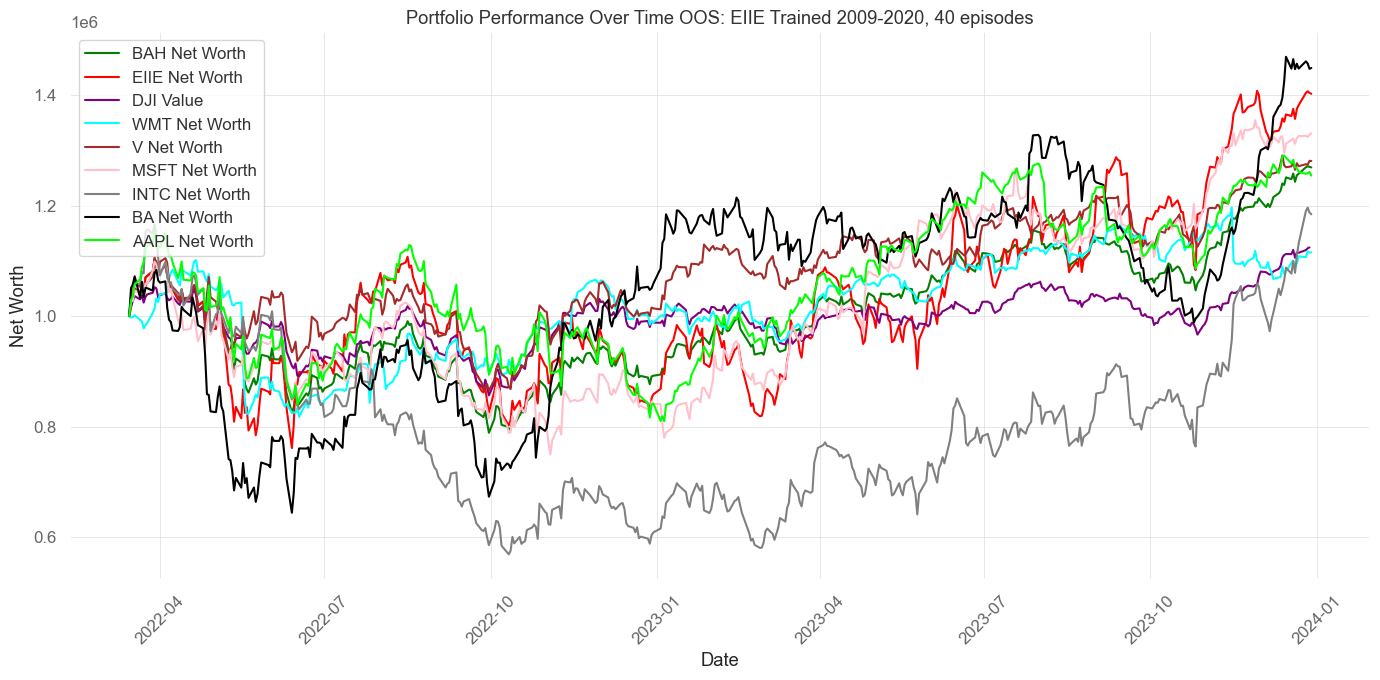

In [51]:
import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'WMT Net Worth': 'cyan',
    'V Net Worth': 'brown',
    'MSFT Net Worth': 'pink',
    'INTC Net Worth': 'gray',
    'BA Net Worth': 'black',
    'AAPL Net Worth': 'lime'
}

# Plot 1: OOS Portfolio Performance
plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.plot(merged_df['Date'], merged_df['WMT_net_worth'], label='WMT Net Worth', color=color_map['WMT Net Worth'])
plt.plot(merged_df['Date'], merged_df['V_net_worth'], label='V Net Worth', color=color_map['V Net Worth'])
plt.plot(merged_df['Date'], merged_df['MSFT_net_worth'], label='MSFT Net Worth', color=color_map['MSFT Net Worth'])
plt.plot(merged_df['Date'], merged_df['INTC_net_worth'], label='INTC Net Worth', color=color_map['INTC Net Worth'])
plt.plot(merged_df['Date'], merged_df['BA_net_worth'], label='BA Net Worth', color=color_map['BA Net Worth'])
plt.plot(merged_df['Date'], merged_df['AAPL_net_worth'], label='AAPL Net Worth', color=color_map['AAPL Net Worth'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [52]:
import pprint

final_returns = {
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'WMT': merged_df['WMT_net_worth'].iloc[-1],
    'V': merged_df['V_net_worth'].iloc[-1],
    'MSFT': merged_df['MSFT_net_worth'].iloc[-1],
    'AAPL': merged_df['AAPL_net_worth'].iloc[-1],
    'BA': merged_df['BA_net_worth'].iloc[-1],
    'INTC': merged_df['INTC_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'AAPL': 1253996.0,
 'BA': 1448998.5,
 'BAH': 1268938.0,
 'CRP': 1312324.125,
 'EIIE': 1402138.25,
 'INTC': 1184103.5,
 'MSFT': 1330797.5,
 'V': 1280554.375,
 'WMT': 1115177.375}


In [53]:
import numpy as np
import pprint


# Calculate daily returns for each specified portfolio
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['WMT_opt_daily_return'] = merged_df['WMT_net_worth'].pct_change()
merged_df['V_opt_daily_return'] = merged_df['V_net_worth'].pct_change()
merged_df['MSFT_opt_daily_return'] = merged_df['MSFT_net_worth'].pct_change()
merged_df['AAPL_opt_daily_return'] = merged_df['AAPL_net_worth'].pct_change()
merged_df['BA_opt_daily_return'] = merged_df['BA_net_worth'].pct_change()
merged_df['INTC_opt_daily_return'] = merged_df['INTC_net_worth'].pct_change()

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate the Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'].dropna(), risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'].dropna(), risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'].dropna(), risk_free_rate),
    'WMT': calculate_sharpe_ratio(merged_df['WMT_opt_daily_return'].dropna(), risk_free_rate),
    'V': calculate_sharpe_ratio(merged_df['V_opt_daily_return'].dropna(), risk_free_rate),
    'MSFT': calculate_sharpe_ratio(merged_df['MSFT_opt_daily_return'].dropna(), risk_free_rate),
    'AAPL': calculate_sharpe_ratio(merged_df['AAPL_opt_daily_return'].dropna(), risk_free_rate),
    'BA': calculate_sharpe_ratio(merged_df['BA_opt_daily_return'].dropna(), risk_free_rate),
    'INTC': calculate_sharpe_ratio(merged_df['INTC_opt_daily_return'].dropna(), risk_free_rate),

}


pprint.pprint(sharpe_ratios)

{'AAPL': 0.5129864228095294,
 'BA': 0.6854739492077354,
 'BAH': 0.6336438353232846,
 'CRP': 0.7081643027043993,
 'EIIE': 0.6213247093122045,
 'INTC': 0.38468695947088016,
 'MSFT': 0.6126790835701302,
 'V': 0.6322905918864468,
 'WMT': 0.29770898180857375}


In [54]:
import numpy as np
import pandas as pd


# Define a function to calculate the max drawdown
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

# Calculate max drawdowns for each portfolio
max_drawdowns = {
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'WMT': max_drawdown(merged_df['WMT_net_worth']),
    'V': max_drawdown(merged_df['V_net_worth']),
    'MSFT': max_drawdown(merged_df['MSFT_net_worth']),
    'AAPL': max_drawdown(merged_df['AAPL_net_worth']),
    'BA': max_drawdown(merged_df['BA_net_worth']),
    'INTC': max_drawdown(merged_df['INTC_net_worth']),
}

pprint.pprint(max_drawdowns)


{'AAPL': -0.29824790411131186,
 'BA': -0.40557187426849883,
 'BAH': -0.28475770822238344,
 'CRP': -0.28321465895552556,
 'EIIE': -0.3094322025670666,
 'INTC': -0.5121011616506284,
 'MSFT': -0.31769845641219396,
 'V': -0.21837345808179476,
 'WMT': -0.2573968827167362}


In [55]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'INTC': calculate_up_days_ratio(merged_df['INTC_opt_daily_return']),
    'WMT': calculate_up_days_ratio(merged_df['WMT_opt_daily_return']),
    'V': calculate_up_days_ratio(merged_df['V_opt_daily_return']),
    'MSFT': calculate_up_days_ratio(merged_df['MSFT_opt_daily_return']),
    'AAPL': calculate_up_days_ratio(merged_df['AAPL_opt_daily_return']),
    'BA': calculate_up_days_ratio(merged_df['BA_opt_daily_return']),
}

pprint.pprint(up_days_ratios)

{'AAPL': 0.5299334811529933,
 'BA': 0.532150776053215,
 'BAH': 0.5188470066518847,
 'CRP': 0.5254988913525499,
 'EIIE': 0.5077605321507761,
 'INTC': 0.5099778270509978,
 'MSFT': 0.5144124168514412,
 'V': 0.5277161862527716,
 'WMT': 0.5543237250554324}


In [56]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq     df         F    PR(>F)
Portfolio  0.000045    1.0  0.109152  0.741189
Residual   0.367478  900.0       NaN       NaN


In [57]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.028380
2      0.005958
3      0.014793
4     -0.008515
5      0.015069
         ...   
447    0.002281
448    0.009353
449    0.001329
450   -0.000830
451   -0.000710
Name: BAH_opt_daily_return, Length: 451, dtype: float64
t-statistic: 0.33038116591226363
p-value: 0.7411888618471949
